In [24]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sys
from tqdm.notebook import tqdm

sys.path.append('/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/')
from optimise_patient import Patient_opt

In [26]:
patients = pd.read_pickle('patient_df.pickle')

total = pd.read_pickle('/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/December_Datat_32.pickle')
patients = total.groupby('Patient_Number').sample(1).reset_index().iloc[:,:44]#total = truncate(total, start=1000, end=1800)

In [37]:
po = Patient_opt(patients, mutpb=0.10, n_indviduals=100, n_gens=500)

po.run_optimisation()

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'solution' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
100%|██████████| 500/500 [00:19<00:00, 25.97it/s]


In [38]:
fits = np.array([p['Fitnesses'].max() for p in po.results])

In [39]:
df = pd.DataFrame(po.results).iloc[np.argmax(fits),:]

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/statsmodels/duration/survfunc.py:546: RuntimeWarning: divide by zero encountered in log
  denom = np.sqrt(nn) * np.log(self.surv_prob)


13.571803936489252 0.0002296086083531934


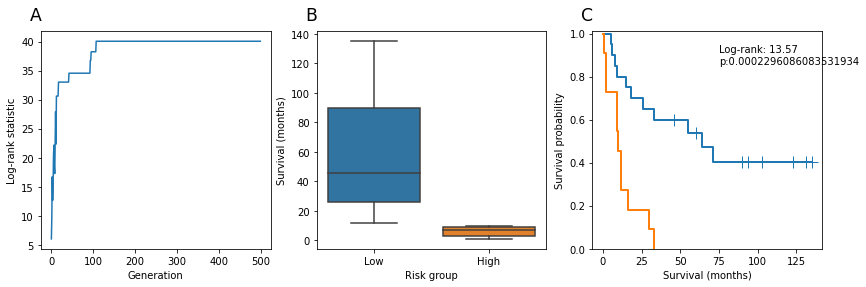

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4),ncols=3)

best = np.argmax(df['Fitnesses'])

duration = patients['survival (months)'].values
death_obs = (patients['DiedvsAlive'] == 'Died').values
groups = np.array(df['Individuals'][best])==1
patients['Groups'] = groups

# Perform log-rank test to determine statistic to maximise
stat, p = sm.duration.survdiff(duration, death_obs, groups)

sft = sm.SurvfuncRight(duration[groups], death_obs[groups])
lcb, ucb = sft.simultaneous_cb()
#ax.fill_between(sft.surv_times, lcb, ucb, color='lightblue')

sff = sm.SurvfuncRight(duration[~groups], death_obs[~groups])
lcb, ucb = sff.simultaneous_cb()
#ax.fill_between(sff.surv_times, lcb, ucb, color='orange')

ax1.plot(fits)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Log-rank statistic')

sns.boxplot(data=patients, y='survival (months)', x='Opt_Group', ax=ax2)
ax2.set_ylabel('Survival (months)')
ax2.set_xlabel('Risk group')
ax2.set_xticklabels(['Low', 'High'])

sft.plot(ax=ax3);
sff.plot(ax=ax3);
ax3.set_xlabel('Survival (months)')
ax3.set_ylabel('Survival probability')

[ax.text(-0.05, 1.05, let, size='xx-large', transform=ax.transAxes) for ax, let in zip((ax1, ax2, ax3), string.ascii_uppercase)]

if p < 0.0001: p = '<0.0001'
ax3.text(0.55, 0.85, f'Log-rank: {stat:0.2f}\np:{p}', size='medium', transform=ax3.transAxes)

print(stat, p)
fig.savefig('/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Optimisation_Curve.pdf', bbox_inches='tight')

In [41]:
ax2

<AxesSubplot:xlabel='Risk group', ylabel='Survival (months)'>